In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import LabelEncoder


In [2]:
train = pd.read_csv("queries.csv")

commands = train['command'].values
intents = train['intent'].values

print(train.head())
train['intent'].value_counts(normalize = True)

assert train['intent'].isna().sum() == 0, "There are NaN values in the 'intent' column"
assert train['command'].isna().sum() == 0, "There are NaN values in the 'command' column"

                              command       intent
0                      can I eat snow  SearchQuery
1         can I drink coffee at night  SearchQuery
2            how do I fix my computer  SearchQuery
3  where to go during school holidays  SearchQuery
4       what are popular places to go  SearchQuery


In [3]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(commands)
sequences = tokenizer.texts_to_sequences(commands)
word_index = tokenizer.word_index

# Pad sequences
max_sequence_length = 100
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Optionally save the tokenizer for future use
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [4]:
import numpy as np
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(intents)
labels = to_categorical(labels)

np.save('classes.npy', label_encoder.classes_)

In [5]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [6]:
import numpy as np
import struct

def load_word2vec_format(file_path):
    with open(file_path, 'rb') as f:
        # Read the number of words and the dimensionality
        header = f.readline()
        vocab_size, embedding_dim = map(int, header.split())
        
        # Initialize an empty dictionary for the embeddings
        word_embeddings = {}
        
        # Read each word and its corresponding vector
        for _ in range(vocab_size):
            # Read the word
            word = []
            while True:
                char = f.read(1)
                if char == b' ':
                    break
                word.append(char)
            word = b''.join(word).decode('utf-8')
            
            # Read the vector
            vector = np.array(struct.unpack('f' * embedding_dim, f.read(embedding_dim * 4)))
            word_embeddings[word] = vector
            
    return word_embeddings

# Load Word2Vec embeddings
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word_embeddings = load_word2vec_format(word2vec_path)

# Create embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = word_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [7]:
print(len(label_encoder.classes_))

4


In [8]:
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU


model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Conv1D(filters=64, kernel_size=8))
model.add(LeakyReLU(alpha=0.025))
model.add(Conv1D(128, 8, padding='same'))
model.add(LeakyReLU(alpha=0.02))
model.add(Conv1D(128, 8, padding='same'))
model.add(LeakyReLU(alpha=0.015))
model.add(Conv1D(64, 8, padding='same'))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.015))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.015))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


c:\Users\Chrystal Lim\anaconda3\envs\intent\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\Chrystal Lim\anaconda3\envs\intent\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [9]:
model_checkpoint_filepath = "classify_intent_word2vec.keras"
callbacks_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_filepath,
    save_weights_only=False,
    monitor="val_accuracy",#val_loss
    mode="max",#max
    save_best_only=True
)

early_stop = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=12,         # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

In [10]:
optimizer = Adam(learning_rate=0.00028)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
2
# Train the model
history = model.fit(X_train, y_train, epochs=70, batch_size=25, validation_data=(X_val, y_val), verbose=2, callbacks=[callbacks_checkpoint,early_stop])


Epoch 1/70
8/8 - 14s - 2s/step - accuracy: 0.3679 - loss: 1.3749 - val_accuracy: 0.5510 - val_loss: 1.3776
Epoch 2/70
8/8 - 0s - 36ms/step - accuracy: 0.4715 - loss: 1.2822 - val_accuracy: 0.5918 - val_loss: 1.3601
Epoch 3/70
8/8 - 0s - 33ms/step - accuracy: 0.5130 - loss: 1.1409 - val_accuracy: 0.6531 - val_loss: 1.3380
Epoch 4/70
8/8 - 0s - 30ms/step - accuracy: 0.6425 - loss: 1.0346 - val_accuracy: 0.6531 - val_loss: 1.3012
Epoch 5/70
8/8 - 0s - 27ms/step - accuracy: 0.6321 - loss: 0.9589 - val_accuracy: 0.8163 - val_loss: 1.2675
Epoch 6/70
8/8 - 0s - 25ms/step - accuracy: 0.6891 - loss: 0.8305 - val_accuracy: 0.7959 - val_loss: 1.2149
Epoch 7/70
8/8 - 0s - 19ms/step - accuracy: 0.7513 - loss: 0.7768 - val_accuracy: 0.7551 - val_loss: 1.1556
Epoch 8/70
8/8 - 0s - 20ms/step - accuracy: 0.7824 - loss: 0.6335 - val_accuracy: 0.7755 - val_loss: 1.1298
Epoch 9/70
8/8 - 0s - 23ms/step - accuracy: 0.7876 - loss: 0.6422 - val_accuracy: 0.7347 - val_loss: 1.0627
Epoch 10/70
8/8 - 0s - 19ms/s

Plot graph


In [11]:
import pylab as plt

In [12]:
model.evaluate(X_val,y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9384 - loss: 0.2330


[0.24450337886810303, 0.9387755393981934]

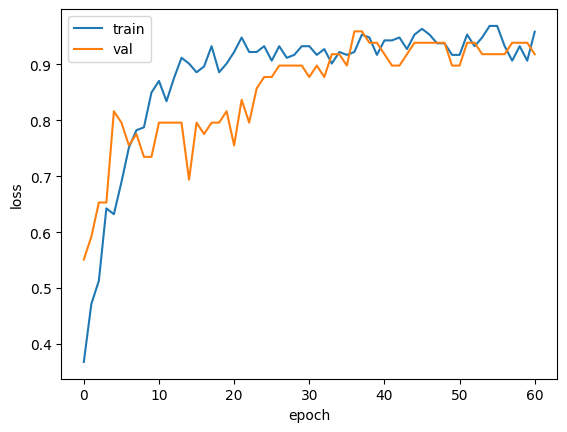

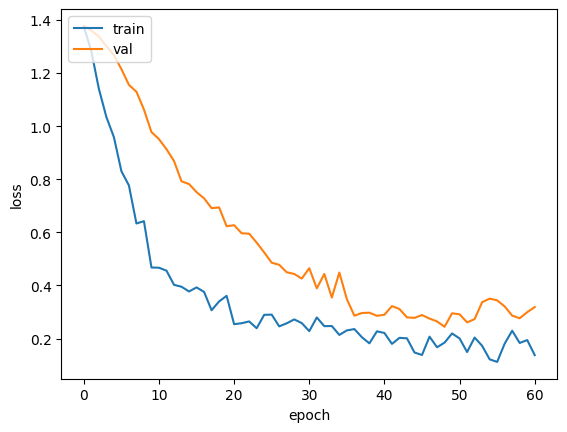

In [13]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_history(history)

def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_history(history)

In [14]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_val_labels, y_pred_labels, average='macro')
recall = recall_score(y_val_labels, y_pred_labels, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

precision_per_class = precision_score(y_val_labels, y_pred_labels, average=None)
recall_per_class = recall_score(y_val_labels, y_pred_labels, average=None)

print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Precision: 0.8875
Recall: 0.8916666666666666
Precision per class: [0.8  0.75 1.   1.  ]
Recall per class: [0.66666667 1.         1.         0.9       ]


In [15]:
from tensorflow.keras.models import load_model
model_eval = load_model('classify_intent_word2vec.keras')

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle

# Sample new texts
new_texts = ["what is the meaning of life",
             "open the wikipedia page",
             "search for capstone",
             "who is george washington",
             "go to the next page",
             "scroll down"]

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Tokenize and pad the new texts
new_sequences = tokenizer.texts_to_sequences(new_texts)
max_sequence_length = 100  # Same max_sequence_length as used during training
new_data = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Make predictions
predictions = model_eval.predict(new_data)

# Convert predictions to class labels (indices)
predicted_classes = predictions.argmax(axis=-1)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the label encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

# Decode predicted classes
predicted_labels = label_encoder.inverse_transform(predicted_classes)
print(predicted_labels)

['SearchQuery' 'OpenSearchResult' 'SearchQuery' 'SearchQuery'
 'BrowserCommand' 'BrowserCommand']
